In [ ]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d robikscube/hourly-energy-consumption

In [3]:
import zipfile
with zipfile.ZipFile('/content/hourly-energy-consumption.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('dark_background')

In [5]:
df=pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [7]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

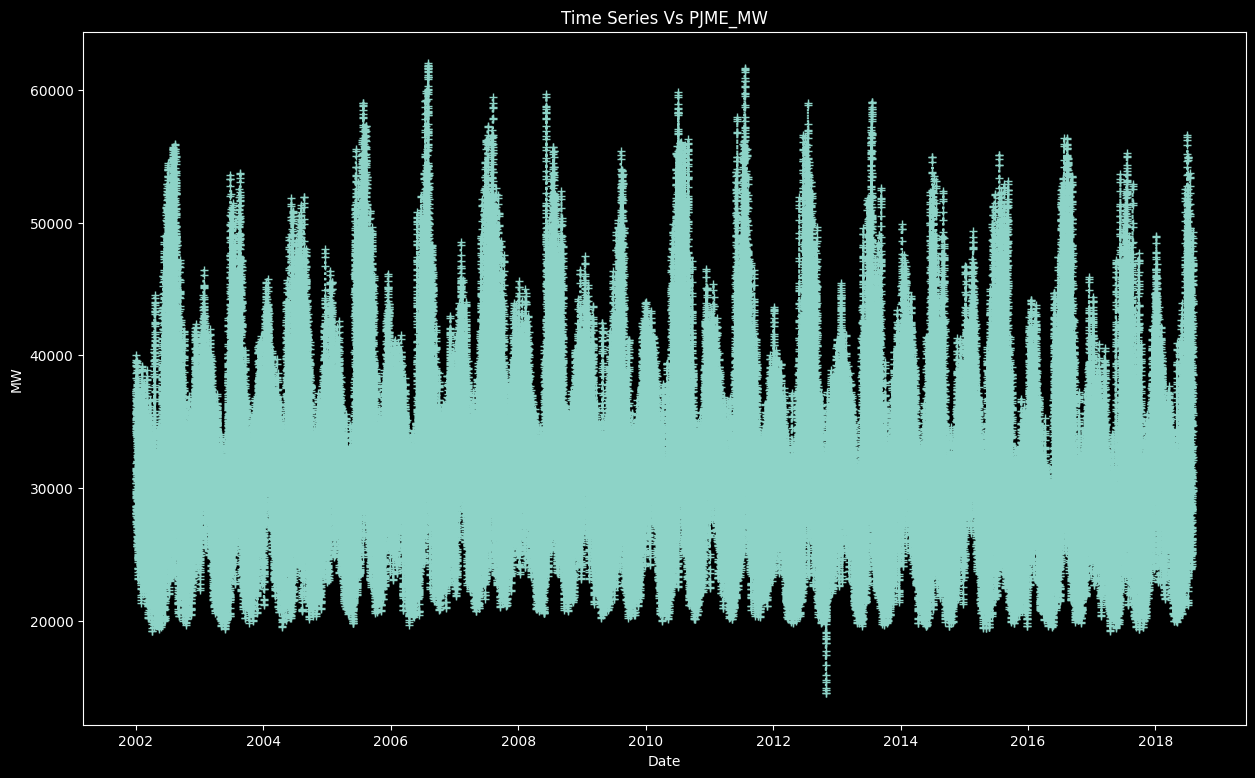

In [8]:
plt.figure(figsize=(15, 9))
plt.plot(df.index, df['PJME_MW'], marker='+', linestyle=':')
plt.title('Time Series Vs PJME_MW')
plt.xlabel('Date')
plt.ylabel('MW')
plt.show()

In [11]:
weekdata = df.iloc[(df.index>'01-01-2010') & (df.index<'01-08-2010')].sort_index()

In [12]:
weekdata

,PJME_MW
Datetime,
2010-01-01 01:00:00,30075.0
2010-01-01 02:00:00,28907.0
2010-01-01 03:00:00,27906.0
2010-01-01 04:00:00,27373.0
2010-01-01 05:00:00,27411.0
...,...
2010-01-07 19:00:00,41262.0
2010-01-07 20:00:00,40846.0
2010-01-07 21:00:00,40059.0


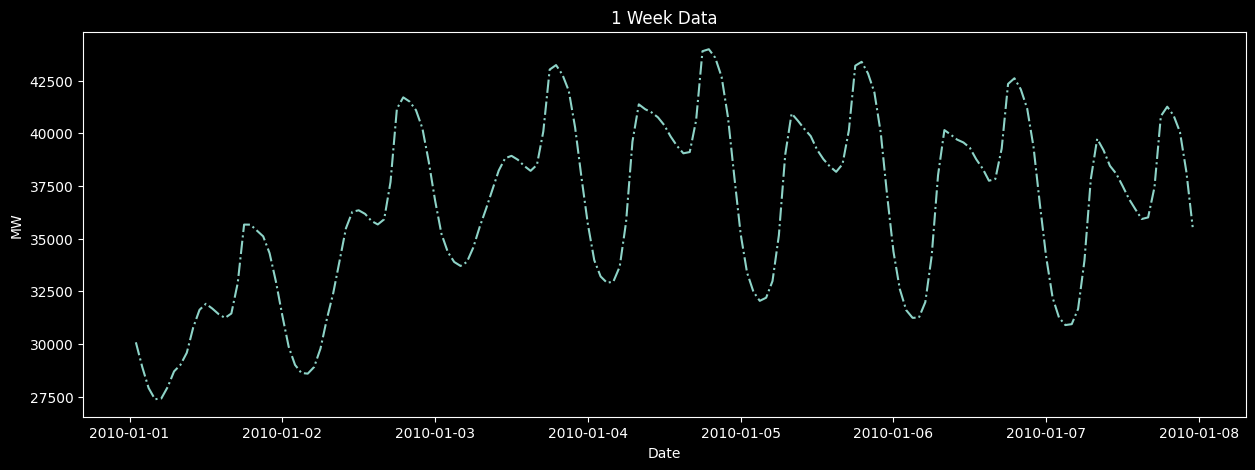

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(weekdata.index, weekdata['PJME_MW'], marker='', linestyle='-.')
plt.title('1 Week Data')
plt.xlabel('Date')
plt.ylabel('MW')
plt.show()

In [14]:
daydata = df.iloc[(df.index>'01-04-2010') & (df.index<'01-05-2010')].sort_index()

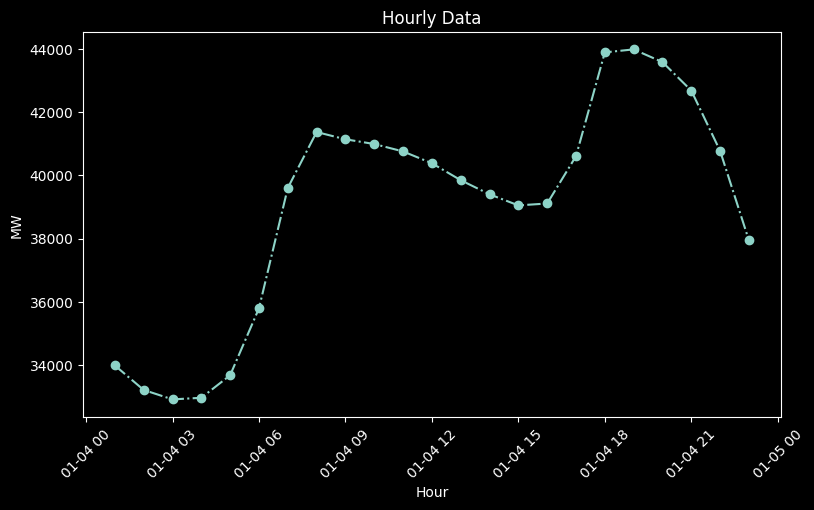

In [15]:
plt.figure(figsize=(9, 5))
plt.plot(daydata.index, daydata['PJME_MW'], marker='o', linestyle='-.')
plt.xticks(rotation=45)
plt.title('Hourly Data')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.show()

In [16]:
FirstQu = df.iloc[(df.index>'01-01-2010') & (df.index<'04-01-2010')].sort_index()
SecondQu = df.iloc[(df.index>'04-01-2010') & (df.index<'07-01-2010')].sort_index()
ThirdQu = df.iloc[(df.index>'07-01-2010') & (df.index<'10-01-2010')].sort_index()
LastQu = df.iloc[(df.index>'10-01-2010') & (df.index<'01-01-2011')].sort_index()

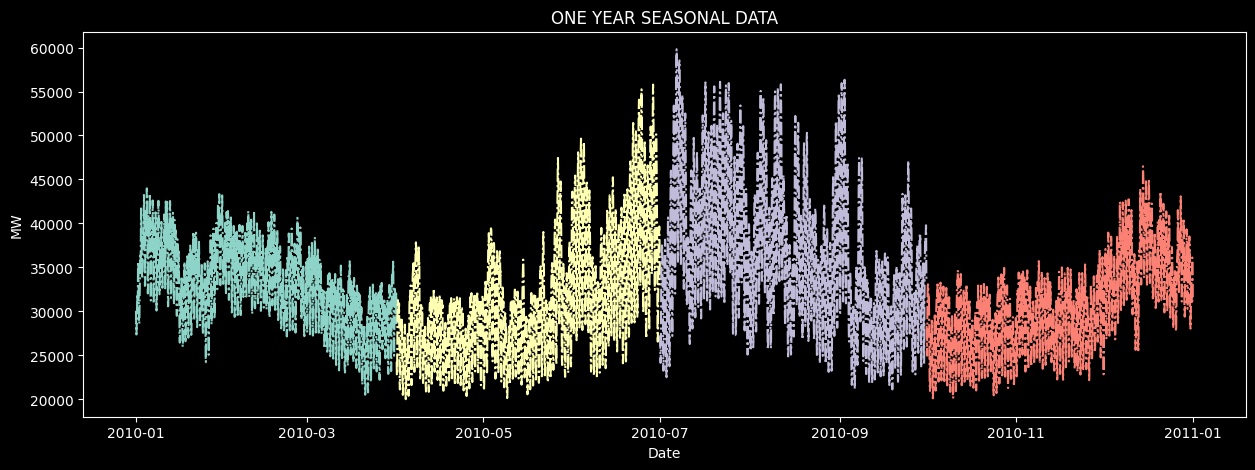

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(FirstQu.index, FirstQu['PJME_MW'], marker='', linestyle='-.')
plt.plot(SecondQu.index, SecondQu['PJME_MW'], marker='', linestyle='-.')
plt.plot(ThirdQu.index, ThirdQu['PJME_MW'], marker='', linestyle='-.')
plt.plot(LastQu.index, LastQu['PJME_MW'], marker='', linestyle='-.')
plt.title('ONE YEAR SEASONAL DATA')
plt.xlabel('Date')
plt.ylabel('MW')
plt.show()

###FEATURE CREATION


In [18]:
def feature_creation(df):
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.day_of_week
  df['dayofyear'] = df.index.day_of_year
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  return df

In [19]:
df = feature_creation(df)
df

,PJME_MW,hour,dayofweek,dayofyear,quarter,month,year
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,1,2002
2002-01-01 02:00:00,29265.0,2,1,1,1,1,2002
2002-01-01 03:00:00,28357.0,3,1,1,1,1,2002
2002-01-01 04:00:00,27899.0,4,1,1,1,1,2002
2002-01-01 05:00:00,28057.0,5,1,1,1,1,2002
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,214,3,8,2018
2018-08-02 21:00:00,43256.0,21,3,214,3,8,2018
2018-08-02 22:00:00,41552.0,22,3,214,3,8,2018


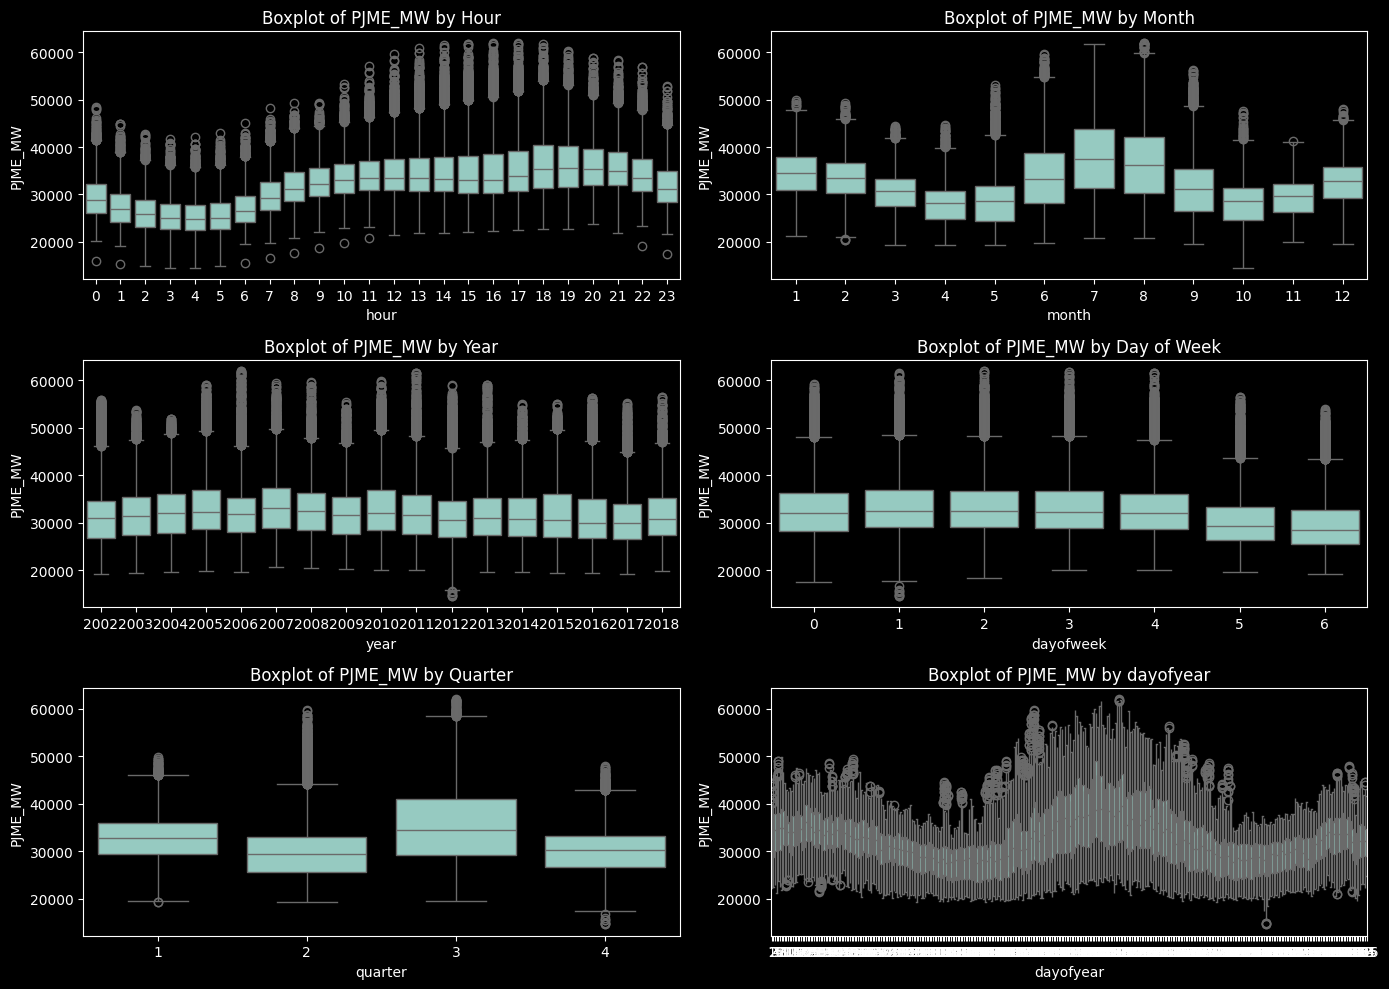

In [20]:
params = [
    {'x': 'hour', 'title': 'Boxplot of PJME_MW by Hour'},
    {'x': 'month', 'title': 'Boxplot of PJME_MW by Month'},
    {'x': 'year', 'title': 'Boxplot of PJME_MW by Year'},
    {'x': 'dayofweek', 'title': 'Boxplot of PJME_MW by Day of Week'},
    {'x': 'quarter', 'title': 'Boxplot of PJME_MW by Quarter'},
    {'x': 'dayofyear', 'title': 'Boxplot of PJME_MW by dayofyear'}
]
custom_palette = sns.color_palette("husl", len(params))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, param in enumerate(params):
    sns.boxplot(data=df, x=param['x'], y='PJME_MW', ax=axes[i])
    axes[i].set_title(param['title'])

plt.tight_layout()
plt.show()

### SPLITING TIME SERIES DATA WITH 5 FOLDS

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

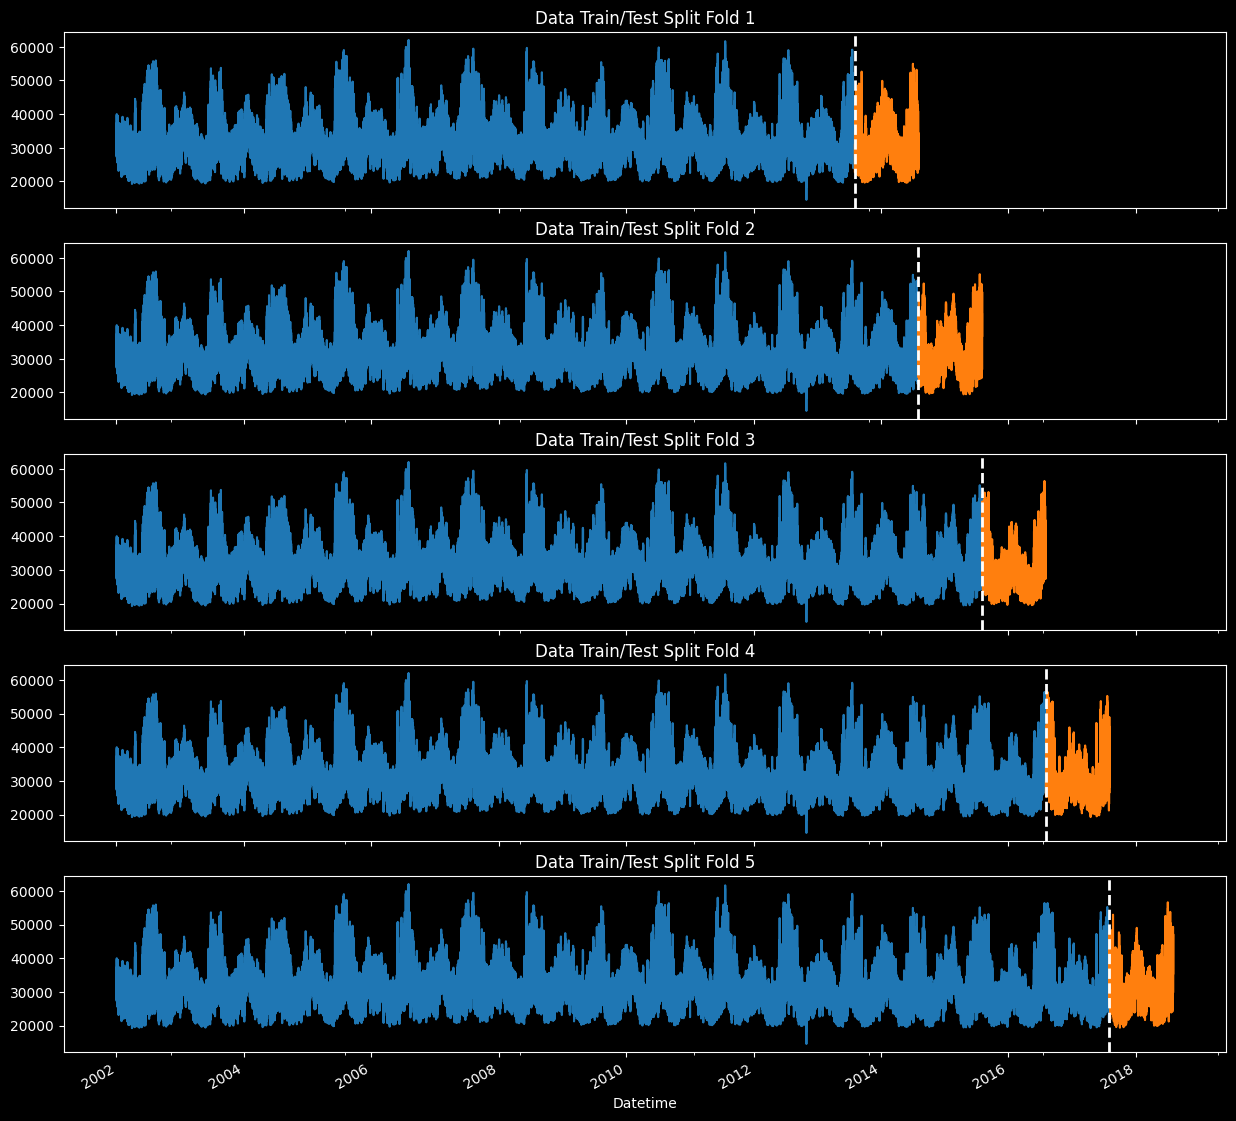

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15),
                       sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['PJME_MW'].plot(ax=axs[fold],
                          color=color_pal[0])
    test['PJME_MW'].plot(ax=axs[fold],
                         color=color_pal[1])

    axs[fold].set_title(f'Data Train/Test Split Fold {fold+1}')
    axs[fold].axvline(train.index.max(), color='white', ls='--', lw=2)

    fold += 1

In [21]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = ['PJME_MW']
preds = []
scores = []

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:33:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-42-1ca82ecbdcf9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=y_pred


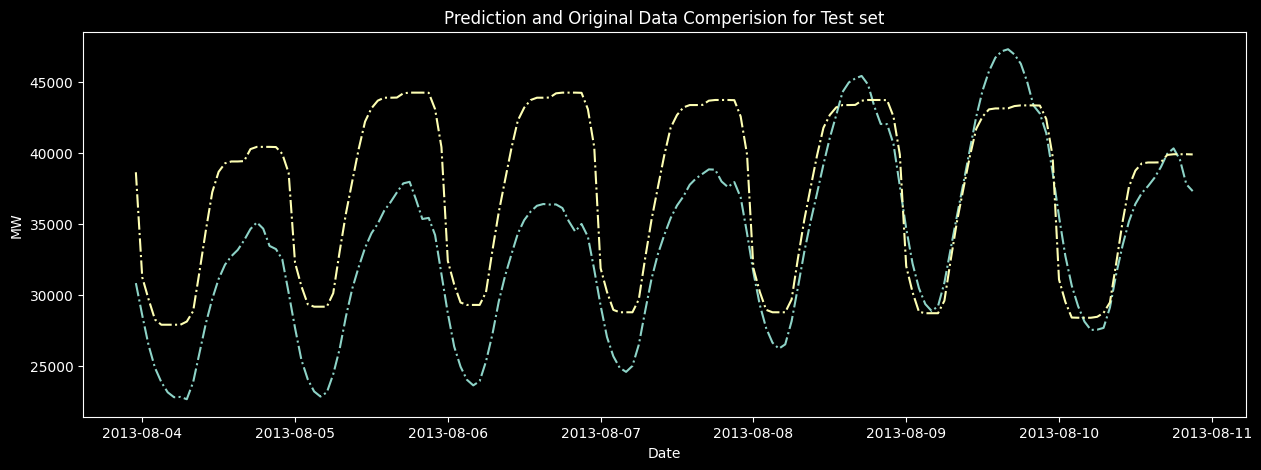

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:34:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-42-1ca82ecbdcf9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=y_pred


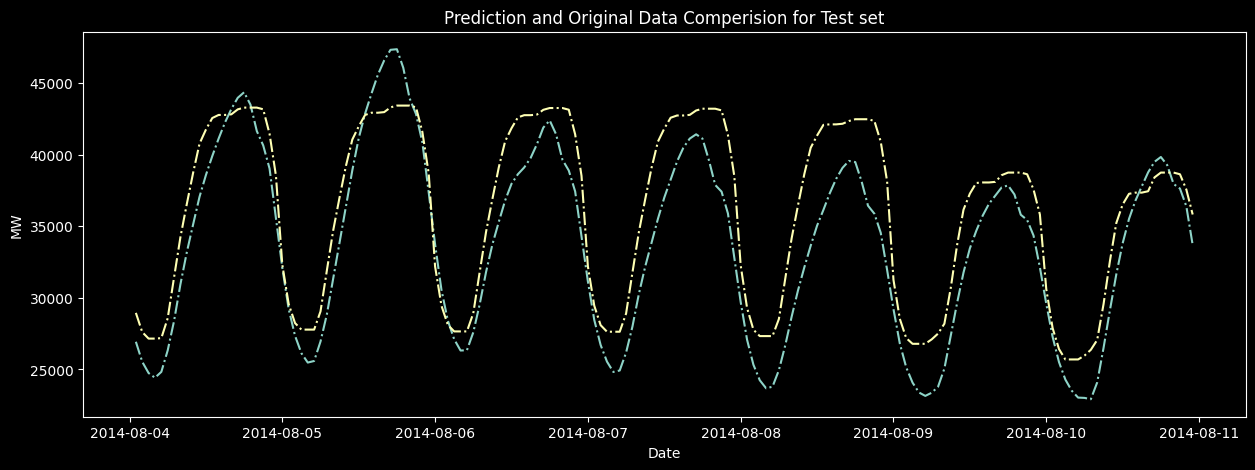

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:34:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-42-1ca82ecbdcf9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=y_pred


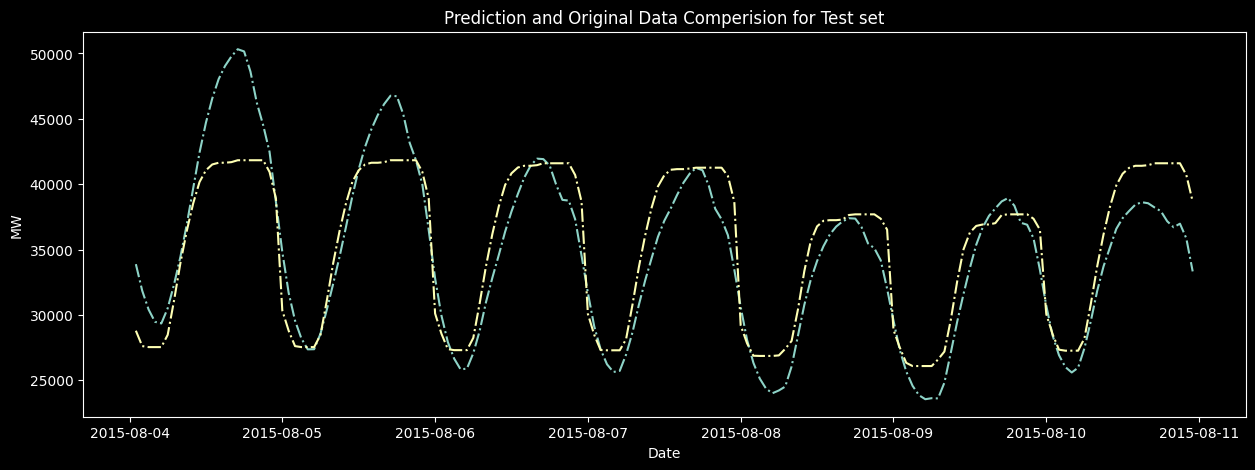

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:34:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-42-1ca82ecbdcf9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=y_pred


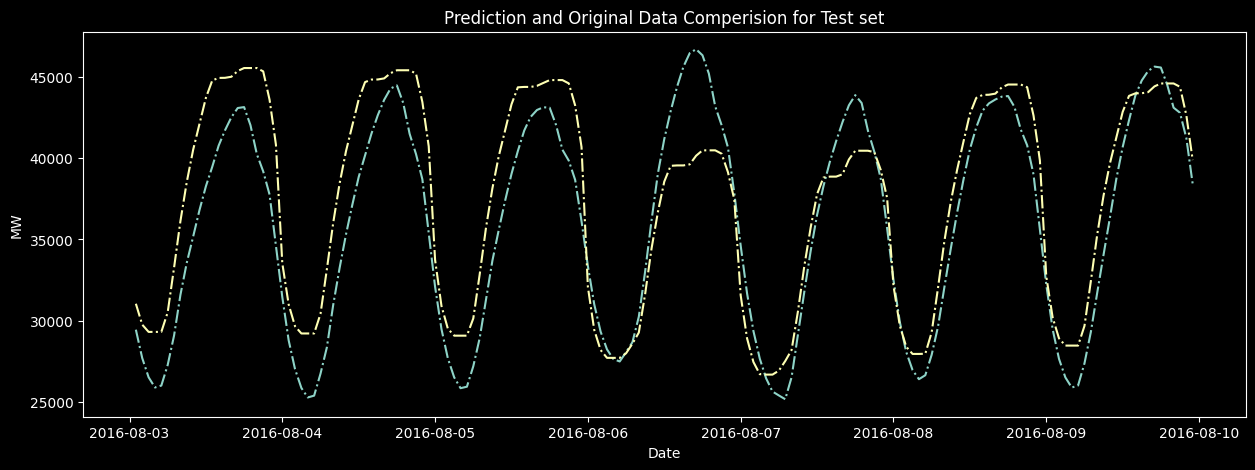

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:34:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-42-1ca82ecbdcf9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=y_pred


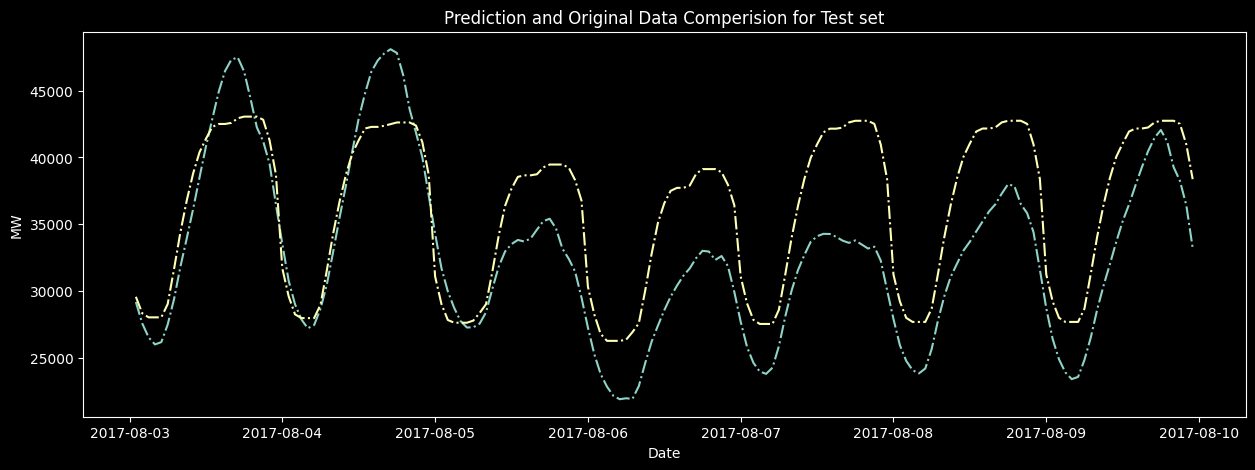

In [42]:
for train_idx, test_idx in tss.split(df):

    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=1_000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,verbose=False)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False)

    y_pred = reg.predict(X_test)
    test['Prediction']=y_pred
    graph = test.iloc[:167, :]
    plt.figure(figsize=(15, 5))
    plt.plot(graph.index, graph['PJME_MW'], marker='', linestyle='-.')
    plt.plot(graph.index, graph['Prediction'], marker='', linestyle='-.')
    plt.title('Prediction and Original Data Comperision for Test set')
    plt.xlabel('Date')
    plt.ylabel('MW')
    plt.show()
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [23]:
print(f'Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds: 3675.4293
Fold scores: [3698.7023222886064, 3447.526551948761, 3566.3561846312027, 3759.7476643894774, 3904.8137258415954]


### FUTURE DATA PREDICTION FOR 2019


In [43]:
df = feature_creation(df)
df = df.sort_index()

In [44]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month',
       'year'],
      dtype='object')

In [45]:
FEATURES = ['hour', 'dayofweek', 'dayofyear', 'quarter', 'month','year']
TARGET = ['PJME_MW']

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       early_stopping_rounds=50,)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32404.79309
[100]	validation_0-rmse:12536.91744
[200]	validation_0-rmse:5875.04193
[300]	validation_0-rmse:4008.56343
[400]	validation_0-rmse:3546.76519
[499]	validation_0-rmse:3395.98332


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

future data creation

In [46]:
future = pd.date_range('2018-08-03' ,'2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df = feature_creation(future_df)
future_df

,hour,dayofweek,dayofyear,quarter,month,year
2018-08-03 00:00:00,0,4,215,3,8,2018
2018-08-03 01:00:00,1,4,215,3,8,2018
2018-08-03 02:00:00,2,4,215,3,8,2018
2018-08-03 03:00:00,3,4,215,3,8,2018
2018-08-03 04:00:00,4,4,215,3,8,2018
...,...,...,...,...,...,...
2019-07-31 20:00:00,20,2,212,3,7,2019
2019-07-31 21:00:00,21,2,212,3,7,2019
2019-07-31 22:00:00,22,2,212,3,7,2019
2019-07-31 23:00:00,23,2,212,3,7,2019


In [47]:
X_future = future_df[FEATURES]

In [48]:
y_future = reg.predict(X_future)

In [49]:
future_df['PJME_MW'] = y_future

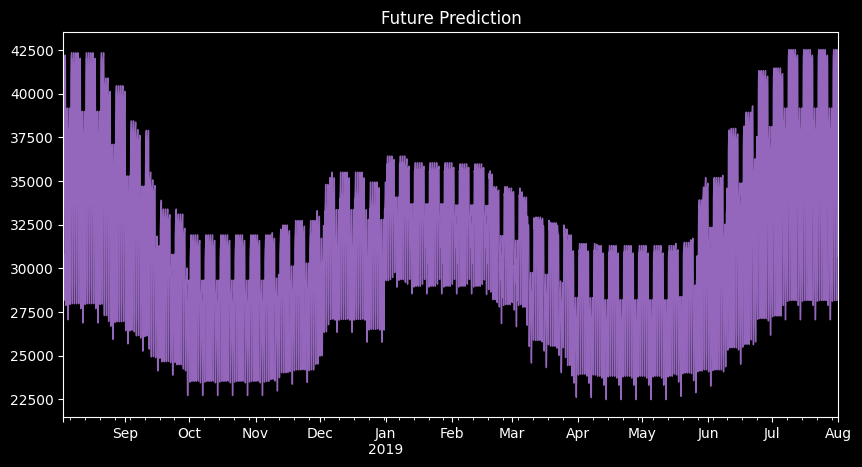

In [50]:
future_df['PJME_MW'].plot(figsize=(10, 5),
                               title='Future Prediction',
                               lw=1,
                               ms=1,
                               color=color_pal[4]);